In [1]:
import pandas as pd
#завантажуємо закодовані маски
url = 'https://raw.githubusercontent.com/Ram81/Airbus-Ship-Detection/master/train_ship_segmentations_v2.csv'
df = pd.read_csv(url,index_col=0)

In [ ]:
import opendatasets as od
od.download("https://www.kaggle.com/mikaelstrauhs/airbus-ship-detection-train-set-30")

In [ ]:
#завантажуємо тренувлаьні фото, складаємо список

In [2]:
import os

input_dir="airbus-ship-detection-train-set-30/test_v3/test_v2/Images"
#input_dir = "images/"
img_size = (128, 128)
num_classes = 2
batch_sizez = 1000

input_img_paths = sorted(
    [
        os.path.join(input_dir, fname)
        for fname in os.listdir(input_dir)
        if fname.endswith(".jpg")
    ]
)

input_img_paths.sort()
print("Number of samples:", len(input_img_paths))
inp=[]
list(set(input_img_paths))
for input_path in zip(input_img_paths[:10]):
    print(input_path)
for ff in range(0,len(input_img_paths)):
        inp.append(input_img_paths[ff].replace("airbus-ship-detection-train-set-30/test_v3/test_v2/Images\\", ""))

Number of samples: 57767
d://test_v3/test_v2/Images\00003e153.jpg | annotations/trimaps/Abyssinian_1.png
d://test_v3/test_v2/Images\0001b1832.jpg | annotations/trimaps/Abyssinian_10.png
d://test_v3/test_v2/Images\00021ddc3.jpg | annotations/trimaps/Abyssinian_100.png
d://test_v3/test_v2/Images\0002d0f32.jpg | annotations/trimaps/Abyssinian_101.png
d://test_v3/test_v2/Images\00031f145.jpg | annotations/trimaps/Abyssinian_102.png
d://test_v3/test_v2/Images\0005d01c8.jpg | annotations/trimaps/Abyssinian_103.png
d://test_v3/test_v2/Images\0005d6d95.jpg | annotations/trimaps/Abyssinian_104.png
d://test_v3/test_v2/Images\0006c52e8.jpg | annotations/trimaps/Abyssinian_105.png
d://test_v3/test_v2/Images\0007b8229.jpg | annotations/trimaps/Abyssinian_106.png
d://test_v3/test_v2/Images\0008d6216.jpg | annotations/trimaps/Abyssinian_107.png


In [3]:
inp[0]

'00003e153.jpg'

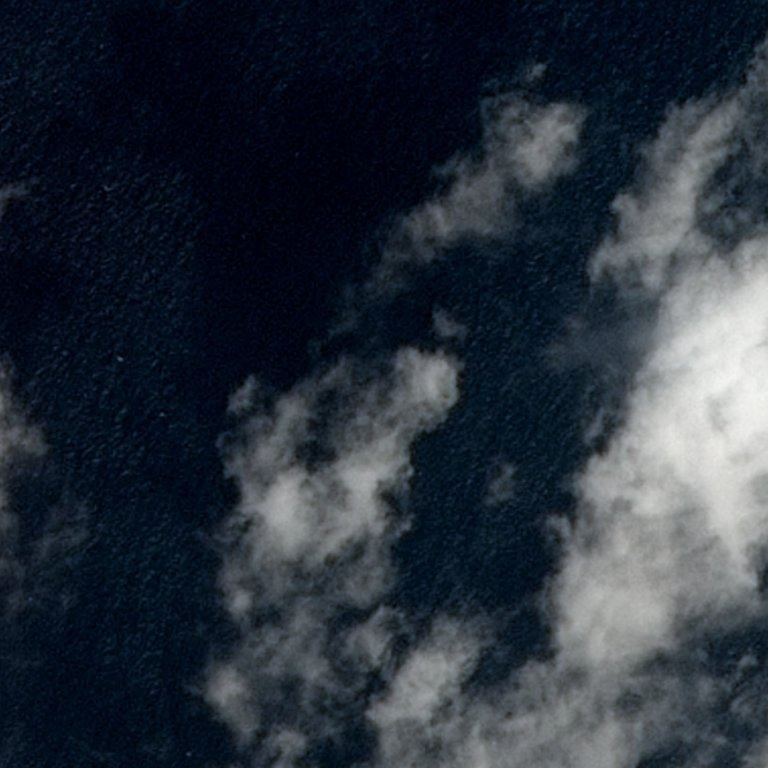

In [29]:
from IPython.display import Image, display
from tensorflow.keras.preprocessing.image import load_img
import PIL
import cv2
from PIL import ImageOps

# Display input image #7
display(Image(filename=input_img_paths[3]))

In [7]:
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T 

In [ ]:
#вище розкодовуємо лейбел-фото

In [25]:
import numpy as np
import matplotlib.pyplot as plt
#ac=rle_decode(df['EncodedPixels'][3])
#plt.imshow(ac)

In [10]:
df['EncodedPixels'] = df['EncodedPixels'].fillna(0) #замінюмо нан на 0
#df=df[:57767]
df.head(8)

,EncodedPixels
ImageId,
00003e153.jpg,0
0001124c7.jpg,0
000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...
000194a2d.jpg,198320 10 199088 10 199856 10 200624 10 201392...
000194a2d.jpg,55683 1 56451 1 57219 1 57987 1 58755 1 59523 ...
000194a2d.jpg,254389 9 255157 17 255925 17 256693 17 257461 ...


In [11]:
df.rename(columns={ df.columns[0]: "EncodedPixels" }, inplace = True)
list(df)

['EncodedPixels']

In [12]:
df = df.reset_index(drop=False)#вибираємо лейбели лише до наявних фото у тренувалному наборі
df.drop_duplicates(subset=['ImageId'], inplace=True)

df['prapor']=df['ImageId'].isin(inp)

In [13]:
df.sort_values(by=['ImageId'])
df.head(9)

,ImageId,EncodedPixels,prapor
0,00003e153.jpg,0,True
1,0001124c7.jpg,0,False
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...,False
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...,False
8,0001b1832.jpg,0,True
9,00021ddc3.jpg,108287 1 109054 3 109821 4 110588 5 111356 5 1...,True
18,0002756f7.jpg,255784 2 256552 4 257319 7 258087 9 258854 12 ...,False
20,0002d0f32.jpg,0,True
21,000303d4d.jpg,0,False


In [14]:
df=df[df['prapor']==True]

In [15]:
len(df)

57767

In [16]:
df.reset_index(drop=True, inplace=True)
df.drop(columns=['prapor'], inplace=True)

In [17]:
df.shape

(57767, 2)

In [19]:
from tensorflow.keras import layers
from tensorflow import keras

def get_model(img_size, num_classes):
    inputs = keras.Input(shape=img_size + (3,))

    ### здійснюємо згортку та пулінг чергово
    x = layers.Conv2D(32, 3, strides=2, padding="same")(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # residual

    for filters in [64, 128, 256]:
        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(filters, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual]) 
        previous_block_activation = x  

    ### РУХАЄМОСЬ У ЗВОРОТНЬОМУ НАПРЯМКУ

    for filters in [256, 128, 64, 32]:
        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.UpSampling2D(2)(x)

        # residual
        residual = layers.UpSampling2D(2)(previous_block_activation)
        residual = layers.Conv2D(filters, 1, padding="same")(residual)
        x = layers.add([x, residual]) 
        previous_block_activation = x  

    # класифікація чи піксель до корабля чи ні
    outputs = layers.Conv2D(num_classes-1, 2, activation="sigmoid", padding="same")(x)

    model = keras.Model(inputs, outputs)
    return model


keras.backend.clear_session()

model = get_model(img_size, num_classes)

model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 64, 64, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 64, 64, 32)   128         conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 64, 64, 32)   0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [428]:
def dice_coef(y_true, y_pred, smooth=1):
    intersection = K.sum(y_true * y_pred, axis=[1,2,3])
    union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3])
    return K.mean( (2. * intersection + smooth) / (union + smooth), axis=0)

In [21]:
import random

#вибір входу та виходу для тренування
i = random.randint(0,5000)
def getx(odyn, dva):
  xx = np.zeros((dva-odyn,) + (128,128) + (3,), dtype="float32")
  count2=0
  for j in range (odyn,dva):
          img =PIL.ImageOps.autocontrast(load_img(input_img_paths[j], target_size=(128,128,3)))
          img=np.array(img)
          img2 = (img - np.min(img))/np.ptp(img) #нормалізація іксів
          xx[count2] = np.array(img2)
          count2+=1
  return xx
def gety(odyn,dva):
  y = np.zeros((dva-odyn,) + (128,128) + (1,), dtype="float32")
  count=0
  for j in range (odyn,dva):
            if df['EncodedPixels'][j]==0:
                img=np.zeros((128,128), dtype=int)
            else:
                img = rle_decode(df['EncodedPixels'][j])
                img=cv2.resize(img, dsize=(128,128), interpolation=cv2.INTER_CUBIC)
            
            img=np.array(img)
            y[count] = img.reshape(128,128,1)

            count+=1
  return y


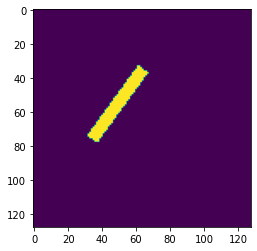

In [359]:
plt.imshow(y[7])

In [483]:
from keras import backend as K
model.compile(optimizer="rmsprop", loss="binary_crossentropy")

callbacks = [
    keras.callbacks.ModelCheckpoint("oxford_segmentation.h5", save_best_only=True)
]

# Тренуємо, зьеррігаємо кращу модель
epochs = 15
model.fit(x=getx(0,5000), y=gety(0,5000),epochs=epochs, validation_split=0.2,callbacks=callbacks)

Epoch 1/15
125/125 [==============================] - 787s 6s/step - loss: 0.0804 - val_loss: 0.0090
Epoch 2/15
125/125 [==============================] - 738s 6s/step - loss: 0.0117 - val_loss: 0.0074
Epoch 3/15
125/125 [==============================] - 608s 5s/step - loss: 0.0062 - val_loss: 0.0083
Epoch 4/15
125/125 [==============================] - 575s 5s/step - loss: 0.0046 - val_loss: 0.0057
Epoch 5/15
125/125 [==============================] - 617s 5s/step - loss: 0.0035 - val_loss: 0.0043
Epoch 6/15
125/125 [==============================] - 569s 5s/step - loss: 0.0033 - val_loss: 0.0038
Epoch 7/15
125/125 [==============================] - 577s 5s/step - loss: 0.0028 - val_loss: 0.0033
Epoch 8/15
125/125 [==============================] - 581s 5s/step - loss: 0.0025 - val_loss: 0.0034
Epoch 9/15
125/125 [==============================] - 630s 5s/step - loss: 0.0023 - val_loss: 0.0038
Epoch 10/15
125/125 [==============================] - 704s 6s/step - loss: 0.0020 - val_lo

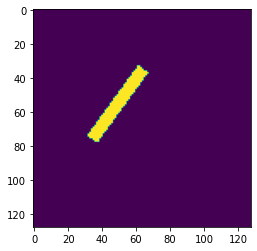

In [439]:
plt.imshow(gety(0,100)[7])

(1, 128, 128, 1)


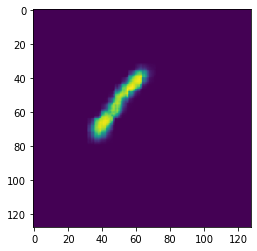

In [35]:
model=keras.models.load_model("oxford_segmentation.h5") #здійснюємо передбачення
xx=getx(0,100)
xx5=xx[7].reshape(1,128,128,3)
img=np.array(model.predict(xx5))
print(img.shape)
nump=np.zeros((128,128))
img=img.reshape(128,128,)
plt.imshow(img)